# MONTE CARLO SIMULATION OF SIR MODEL

In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from numba import jit, prange
import networkx as nx
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from scipy import optimize, stats
from pylab import *
from scipy.ndimage import measurements

In [2]:
@jit(nopython = True)
def init_lattice(L, perc):
    '''
    Returns an initial configuration of size N with N*perc initial infected chosen randomly
    
    INPUTs:
    -size of the lattice
    -percentage of initial infected
    OUTPUTs:
    -lattice
    '''
    N = L**2
    lattice = np.full(N, 0)
    initial_infected = int(N*perc)
    for i in range(initial_infected): lattice[i] = 1
    np.random.shuffle(lattice)
    return lattice

In [3]:
def plot_lattice(lattice, nodesize = 100):
    '''
    Plot a configuration
    '''
    fig = plt.figure(figsize = (6, 6))
    N = len(lattice)
    L = int(np.sqrt(N))
    #L = lattice.shape[0]
    G = nx.grid_2d_graph(L, L)
    pos = dict( (n, n) for n in G.nodes() )
    colors = np.full(N, ["blue"])
    #print(pos)
    for i in range(N):
        if lattice[i] == 1: colors[i] = "red"
        elif lattice[i] == 2: colors[i] = "grey"
    
    colors = (colors.reshape(L, L).T).reshape(-1, N)[0]
    legend_elements = [Line2D([0], [0], marker = "o", color="w",label="Scatter",
                                 markerfacecolor = "blue", markersize = 14),
                           Line2D([0], [0], marker="o", color="w", label="Scatter",
                                  markerfacecolor= "red", markersize=14),
                      Line2D([0], [0], marker="o", color="w", label="Scatter",
                                  markerfacecolor= "gray", markersize=14)]
    
    nx.draw_networkx(G, pos = pos, with_labels = False, labels = None,
                         node_color = colors, node_size = nodesize)
    plt.title("Example of initial state", weight = "bold", size = 16)
    plt.axis('off')
    plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()
    plt.legend(legend_elements, ["Healthy", "Infected", "Recovered"], bbox_to_anchor=(1, 1), loc="upper left", fontsize = 14)
    plt.show()
    return

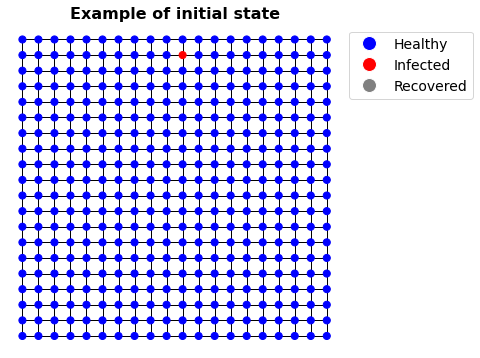

In [4]:
a = init_lattice(20, 1/400)
plot_lattice(a, 50)

In [4]:
@jit(nopython = True)
def build_I(lattice):
    '''
    Returns a list with the positions of the infected nodes
    
    INPUT:
    -lattice
    OUTPUT:
    -a list with positions
    '''
    N = len(lattice)
    I = np.array([2*N], dtype = np.int64)
    for n in prange(N):
        if lattice[n] == 1: I = np.append(I, n)
    return I


@jit(nopython = True)
def SIR(L, I, R, rec_rate):
    '''
    Performs N_infected trials of infections/recovery
    
    INPUTs:
    -lattice linear size
    -list of initial infected
    -list of initial recovered
    -recovery rate
    
    OUTPUTs:
    -new list of infected
    -new list of recovered
    '''
    N = L**2
    c = rec_rate#/(rec_rate + inf_rate)
    n_infected = len(I)-1 #get number of initial infected
    n_recovered = len(R) - 1 #get number of initial recovered
    
    if (len(I)-1) > 0: #check if there is at least one infected
        for j in prange(n_infected): #repeat n_infected times
       
            #get random infected
            i = np.random.randint(1, len(I))
            random_site = I[i]
            
            #recover with prob. c
            if np.random.uniform(0., 1.) < c:
                #idx = I.index(random_site)
                I[i] = I[-1]
                I = I[:-1]
                R = np.append(R, random_site)
                #n_infected -= 1
            else:
                #get a random neighbor
                nbrs = [(random_site-1)%N, (random_site+1)%N, (random_site+L)%N, (random_site-L)%N]
                j = np.random.randint(0, 4)
                random_nbr = nbrs[j]
                #try to infect it if it is susceptible
                if np.any(R == random_nbr)==False and np.any(I == random_nbr)==False:
                    
                    I = np.append(I, random_nbr)
                    

    return I, R

In [5]:
@jit(nopython = True)
def trajectory(L, perc, nsteps, rec_rate):
    '''
    Simulates a "trajectory": at each step the lattice is modified
    
    INPUTs:
    -the linear size of the lattice
    -the percentage of initial infected
    -the number of steps to do
    -recovery rate
    
    OUTPUTs:
    -a vector with the number of the susceptible nodes at each step, including the initial value
    -a vector with the number of the infected nodes at each step, including the initial value
    -a vector with the number of the recovered nodes at each step, including the initial value
    '''
    N = L**2
   
    lattice = init_lattice(L, perc)
    I = build_I(lattice)
    R = np.array([2*N], dtype = np.int64)
    infected = np.zeros(nsteps +1)
    infected[0] = 1
    sus = np.zeros(nsteps +1)
    sus[0] = N-1
    rec = np.zeros(nsteps +1)
    rec[0] = 0


    for i in prange(nsteps+1):
        I, R = SIR(L, I, R, rec_rate)
        rec[i+1] = len(R) - 1
        infected[i+1] = len(I) - 1
        rec[i+1] = len(R) - 1
        sus[i+1] = N - rec[i+1] - infected[i+1]
        if (len(I)-1) == 0:
            sus[i+2:] = (N -(len(R)-1))
            rec[i+2:] = (len(R)-1)
            break   
    return sus, infected, rec

    
@jit(nopython = True)
def simulate(L, perc, ntraj, nsteps, rec_rate):
    
    trajectories = np.zeros((ntraj, nsteps + 1))
    for i in prange(ntraj):
        #tr = trajectory(L, perc, nsteps, rec_rate, surv_prob, dist_sq)
        #trajectories[i][:len(tr)] = tr
        #trajectories[len(tr):] = tr[-1]
        trajectories[i] = trajectory(L, perc, nsteps, rec_rate)
    #trajectories = np.mean(trajectories, axis = 0)
    return trajectories

## Plot one simulation

In [102]:
L = 20
N = L**2
s, i, r = trajectory(L, 1/N, 100, 0.05) #start with one infected node

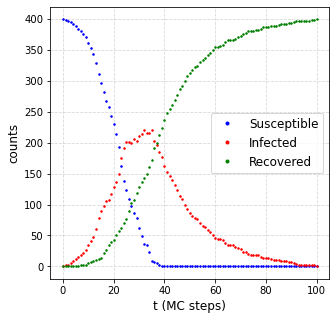

In [114]:
fig = plt.figure(figsize = (5,5))
plt.plot(s, c = "blue", marker = ".", linestyle = "None", label = "Susceptible", markersize = 3)
plt.plot(i, c = "red", marker = ".", linestyle = "None", label = "Infected", markersize = 3)
plt.plot(r, c = "green", marker = ".", linestyle = "None", label = "Recovered", markersize = 3)
plt.xlabel("t (MC steps)", size = 12)
plt.ylabel("counts", size = 12)
plt.legend(fontsize = 12, markerscale = 2)
plt.grid(alpha = 0.5, linestyle = "--")
fig.savefig("presentazione/Images/sir/example.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

## Analysis of cluster size distribution

In [6]:
@jit(nopython = True)
def cluster(L, perc, rec_rate):
    '''
    Returns the number of recovered nodes when the absorbing phase is reached
    
    INPUTs:
    -linear size of the lattice
    -percentage of initial infected
    -recovery rate
    
    OUTPUTs:
    -the number of recovered nodes once the absorbing phase is reached
    '''
    N = L**2
    lattice = init_lattice(L, perc)
    I = build_I(lattice)
    R = np.array([2*N], dtype = np.int64) #put a dummy first element to be able to work with numba (numba has problems with empty lists)
    
    while (len(I) - 1)>0: #repeat till absorbing phase
        I, R = SIR(L, I, R, rec_rate)
    cluster_size = len(R)-1
    return cluster_size

@jit(nopython = True)
def cluster_dist(L, perc, ntraj, rec_rate):
    '''
    Returns the distribution of the cluster size after simulating many times
    
    INPUTs:
    -linear size of the lattice
    -percentage of initial infected
    -number of simulations to do
    -recovery rate
    '''
    sizes = np.zeros(ntraj)
    for i in prange(len(sizes)):
        sizes[i] = cluster(L, perc, rec_rate)
    return sizes

## Critical point and $\theta$

In [11]:
L = 40
N = L**2
sizes_smaller = cluster_dist(L, 1/N, 10**4, 0.16)
sizes_mid = cluster_dist(L, 1/N, 10**4, 0.18)
sizes_g = cluster_dist(L, 1/N, 10**4, 0.19)

In [12]:
s = np.linspace(0, 500, 50)

P_smaller = np.zeros(len(s))
P_mid = np.zeros(len(s))
P_g = np.zeros(len(s))

for i in prange(len(s)):
    size = s[i]
    P_smaller[i] = len(sizes_smaller[sizes_smaller >= size])/len(sizes_smaller)
    P_mid[i] = len(sizes_mid[sizes_mid >= size])/len(sizes_mid)
    P_g[i] = len(sizes_g[sizes_g >= size])/len(sizes_g)

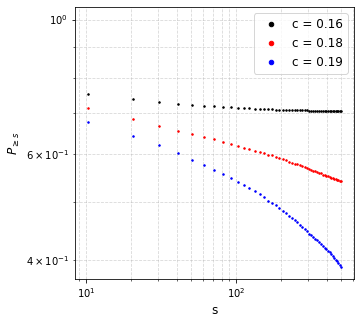

In [20]:
tau = 187/91


fig = plt.figure(figsize = (5,5))
plt.plot(s, P_smaller, marker = ".", linestyle = "None", markersize = 3,
         c = "black", label = "c = 0.16")
plt.plot(s, P_mid, marker = ".", linestyle = "None", markersize = 3,
         c = "red", label = "c = 0.18")
plt.plot(s, P_g, marker = ".", linestyle = "None", markersize = 3,
         c = "blue", label = "c = 0.19")


plt.xscale("log")
plt.yscale("log")
plt.xlabel("s", size = 12)
plt.ylabel(r"$P_{\geq s}$", size = 12)
plt.legend(markerscale = 3, fontsize =12)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.show()
fig.savefig("presentazione/Images/sir/P.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

In [34]:
#@jit(nopython = True)
def find_critical_point(L, perc, ntraj, lower, upper, nintervals):
    
    rates = np.linspace(lower, upper, nintervals)
    taus, r_sq = np.zeros(len(rates)), np.zeros(len(rates))
    s = np.linspace(0, 100, 50)
    P = np.zeros(len(s))
    
    for i in prange(len(rates)):
        sizes = cluster_dist(L, perc, ntraj, rates[i])
        for j in prange(len(s)):
            size = s[j]
            P[j] = len(sizes[sizes >= size])/len(sizes)
        x_range = np.log(s[1:])
        x_range = x_range.reshape(-1,1)
        y_range = np.log(P[1:])
        model = LinearRegression()
        model.fit(x_range, y_range)
        r_sq[i] = model.score(x_range, y_range)
        taus[i] = 2 - model.coef_
    return rates, r_sq, taus

In [36]:
%%time
L = 20
N = L**2
a, b, c = find_critical_point(L, 1/N, 10000, 0.17, 0.18, 5)


i_10 = np.argmax(b)
print("Estimated critical point:",  a[i_10])
print("Relative R_squared:", b[i_10])
print("Estimated tau expontnet:", c[i_10])
print(b)

Estimated critical point: 0.175
Relative R_squared: 0.9995746379413813
Estimated tau expontnet: 2.053032593211227
[0.99415258 0.99891413 0.99957464 0.99940995 0.99804276]
CPU times: user 1min 8s, sys: 1.17 s, total: 1min 9s
Wall time: 1min 14s


In [45]:
np.linspace(0.17, 0.18, 5)

array([0.17  , 0.1725, 0.175 , 0.1775, 0.18  ])

### Restricted set of $c_i$

In [51]:
%%time
L = 20
N = L**2
a, b, c = find_critical_point(L, 1/N, 10000, 0.175, 0.177, 5)


i_10 = np.argmax(b)
print("Estimated critical point:",  a[i_10])
print("Relative R_squared:", b[i_10])
print("Estimated tau expontnet:", c[i_10])
print(b)

Estimated critical point: 0.1765
Relative R_squared: 0.9996109431356418
Estimated tau expontnet: 2.0538093654052614
[0.99955075 0.99791148 0.99937274 0.99961094 0.99906362]
CPU times: user 1min 4s, sys: 367 ms, total: 1min 5s
Wall time: 1min 6s


In [48]:
np.linspace(0.175, 0.177, 5)

array([0.175 , 0.1755, 0.176 , 0.1765, 0.177 ])

In [38]:
%%time
L = 30
N = L**2
a, b, c = find_critical_point(L, 1/N, 10000, 0.17, 0.18, 5)


i_10 = np.argmax(b)
print("Estimated critical point:",  a[i_10])
print("Relative R_squared:", b[i_10])
print("Estimated tau expontnet:", c[i_10])
print(b)

Estimated critical point: 0.175
Relative R_squared: 0.9995529562644712
Estimated tau expontnet: 2.053540820931104
[0.99663997 0.99953313 0.99955296 0.99840256 0.99693779]
CPU times: user 2min 40s, sys: 1.13 s, total: 2min 41s
Wall time: 2min 43s


In [47]:
np.linspace(0.17, 0.18, 5)

array([0.17  , 0.1725, 0.175 , 0.1775, 0.18  ])

In [37]:
%%time
L = 50
N = L**2
a, b, c = find_critical_point(L, 1/N, 10000, 0.17, 0.18, 5)

i_10 = np.argmax(b)
print("Estimated critical point:",  a[i_10])
print("Relative R_squared:", b[i_10])
print("Estimated tau expontnet:", c[i_10])
print(b)

Estimated critical point: 0.175
Relative R_squared: 0.9985309797035988
Estimated tau expontnet: 2.0529571391728005
[0.9926917  0.99845196 0.99853098 0.99824852 0.9977888 ]
CPU times: user 10min 33s, sys: 3.61 s, total: 10min 36s
Wall time: 10min 46s


In [56]:
sizes = cluster_dist(20, 1/400, 10**4, 0.1765)

In [57]:
s = np.linspace(1, 100, 50)
P = np.zeros(len(s))
for i in prange(len(s)):
    size = s[i]
    P[i] = len(sizes[sizes >= size])/len(sizes)
   

In [65]:
x_range = np.log(s[2:])
x_range = x_range.reshape(-1,1)
y_range = np.log(P_mid[2:])
model = LinearRegression()
model.fit(x_range, y_range)
print(model.score(x_range, y_range))
print(2 - model.coef_)

0.9997860460043879
[2.0591334]


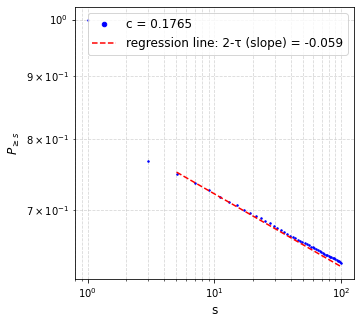

In [69]:
fig = plt.figure(figsize = (5,5))
plt.plot(s, P, marker = ".", linestyle = "None", markersize = 3,
         c = "blue", label = "c = 0.1765")
plt.plot(s[2:], s[2:]**(model.coef_)*np.exp(model.intercept_),
         c = "red", linestyle = "--", linewidth = 1.5,
         label = "regression line: 2-τ (slope) = {}".format(round(model.coef_[0],3)))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("s", size = 12)
plt.ylabel(r"$P_{\geq s}$", size = 12)
plt.legend(markerscale = 3, fontsize =12)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.show()
fig.savefig("presentazione/Images/sir/p_crit.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

## $\gamma/\nu_\perp$

In [108]:
%%time
ntraj = 10**3
Ls = np.arange(10, 80, 5)
S = np.zeros(len(Ls))

for i in range(len(Ls)):
    Ni = Ls[i]**2
    s = cluster_dist(Ls[i], 1/Ni, ntraj, 0.1765)
    s = np.mean(s)
    S[i] = s


CPU times: user 3min 1s, sys: 1.56 s, total: 3min 2s
Wall time: 3min 8s


In [132]:
x_range = np.log(Ls[:])
x_range = x_range.reshape(-1,1)
y_range = np.log(S[:])
model = LinearRegression()
model.fit(x_range, y_range)
print(model.score(x_range, y_range))
print(model.coef_)

0.9997801301274715
[1.79657088]


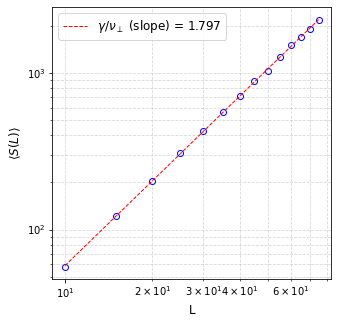

In [131]:
fig = plt.figure(figsize = (5,5))
plt.plot(Ls, S, marker = "o", linestyle = "None", c = "blue", mfc = "None")
plt.plot(Ls, Ls**model.coef_*np.exp(model.intercept_), c = "red",
         linestyle = "--", linewidth = 1,
         label = r"$\gamma/\nu_\perp$ (slope) = {}".format(round(model.coef_[0], 3)))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("L", size = 12)
plt.ylabel(r"$\langle S(L) \rangle$", size = 12)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(fontsize = 12)
plt.show()
fig.savefig("presentazione/Images/sir/S.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

## $\nu_\perp$

In [62]:
%%time
gam_nu = model.coef_
rates = np.linspace(0.1, 0.3, 20)
ntraj = 3*10**3

L1, L2, L3 = 20, 30, 50
y1, y2, y3 = np.zeros(len(rates)), np.zeros(len(rates)), np.zeros(len(rates))

for i in prange(len(rates)):
    c = rates[i]
    S1 = cluster_dist(L1, 1/(L1**2), ntraj, c)
    S1 = np.mean(S1)
    y1[i] = S1*L1**(-gam_nu)
    
    S2 = cluster_dist(L2, 1/(L2**2), ntraj, c)
    S2 = np.mean(S2)
    y2[i] = S2*L2**(-gam_nu)
    
    S3 = cluster_dist(L3, 1/(L3**2), ntraj, c)
    S3 = np.mean(S3)
    y3[i] = S3*L3**(-gam_nu)

CPU times: user 18min 3s, sys: 7.04 s, total: 18min 10s
Wall time: 18min 30s


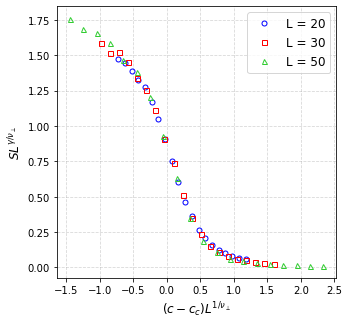

In [105]:
v_perp = 1.33
x1 = (rates - 0.1765)*(L1**(1/v_perp))
x2 = (rates - 0.1765)*(L2**(1/v_perp))
x3 = (rates - 0.1765)*(L3**(1/v_perp))

fig = plt.figure(figsize = (5,5))
plt.plot(x1, y1, c = "blue", marker = "o", linestyle = "None",
         mfc = "None", markersize = 5, label = "L = 20")
plt.plot(x2, y2, c = "red", marker = "s", linestyle = "None",
         mfc = "None", markersize = 5, label = "L = 30")
plt.plot(x3, y3, c = "limegreen", marker = "^", linestyle = "None",
         mfc ="None", markersize = 5, label = "L = 50")
plt.ylabel(r"$SL^{\gamma/\nu_\perp}$", size = 12)
plt.xlabel(r"$(c-c_c)L^{1/\nu_\perp}$", size = 12)
plt.grid(alpha = 0.5, linestyle = "--")
plt.legend(fontsize = 12)
plt.show()
fig.savefig("presentazione/Images/sir/nuperp_133.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

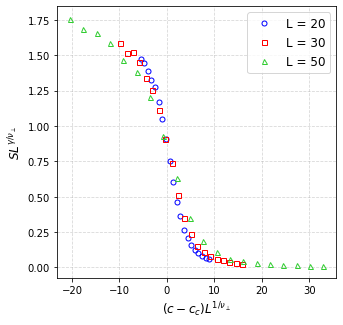

In [106]:
v_perp = 0.7
x1 = (rates - 0.1765)*(L1**(1/v_perp))
x2 = (rates - 0.1765)*(L2**(1/v_perp))
x3 = (rates - 0.1765)*(L3**(1/v_perp))

fig = plt.figure(figsize = (5,5))
plt.plot(x1, y1, c = "blue", marker = "o", linestyle = "None",
         mfc = "None", markersize = 5, label = "L = 20")
plt.plot(x2, y2, c = "red", marker = "s", linestyle = "None",
         mfc = "None", markersize = 5, label = "L = 30")
plt.plot(x3, y3, c = "limegreen", marker = "^", linestyle = "None",
         mfc ="None", markersize = 5, label = "L = 50")
plt.ylabel(r"$SL^{\gamma/\nu_\perp}$", size = 12)
plt.xlabel(r"$(c-c_c)L^{1/\nu_\perp}$", size = 12)
plt.grid(alpha = 0.5, linestyle = "--")
plt.legend(fontsize = 12)
plt.show()
fig.savefig("presentazione/Images/sir/nuperp_07.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

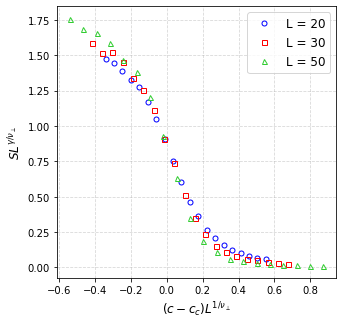

In [107]:
v_perp = 2
x1 = (rates - 0.1765)*(L1**(1/v_perp))
x2 = (rates - 0.1765)*(L2**(1/v_perp))
x3 = (rates - 0.1765)*(L3**(1/v_perp))

fig = plt.figure(figsize = (5,5))
plt.plot(x1, y1, c = "blue", marker = "o", linestyle = "None",
         mfc = "None", markersize = 5, label = "L = 20")
plt.plot(x2, y2, c = "red", marker = "s", linestyle = "None",
         mfc = "None", markersize = 5, label = "L = 30")
plt.plot(x3, y3, c = "limegreen", marker = "^", linestyle = "None",
         mfc ="None", markersize = 5, label = "L = 50")
plt.ylabel(r"$SL^{\gamma/\nu_\perp}$", size = 12)
plt.xlabel(r"$(c-c_c)L^{1/\nu_\perp}$", size = 12)
plt.grid(alpha = 0.5, linestyle = "--")
plt.legend(fontsize = 12)
plt.show()
fig.savefig("presentazione/Images/sir/nuperp_20.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)

## $\beta$

In [189]:
%%time
ntraj = 10**3
Ls = np.arange(10, 80, 5)
M = np.zeros(len(Ls))

for i in range(len(Ls)):
    Ni = Ls[i]**2
    s = cluster_dist(Ls[i], 1/Ni, ntraj, 0.1765)
    s = np.mean(s**2)
    M[i] = s



CPU times: user 2min 56s, sys: 1.56 s, total: 2min 58s
Wall time: 3min 4s


In [191]:
x_range = np.log(Ls[1:])
x_range = x_range.reshape(-1,1)
y_range = np.log(M[1:])
model = LinearRegression()
model.fit(x_range, y_range)
print(model.score(x_range, y_range))
print(model.coef_)

0.9998874814418303
[3.69180458]


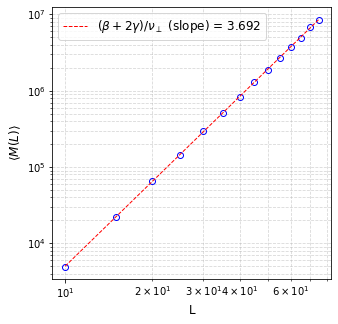

In [204]:
fig = plt.figure(figsize = (5,5))
plt.plot(Ls, M, marker = "o", linestyle = "None", c = "blue", mfc = "None")
plt.plot(Ls, Ls**model.coef_*np.exp(model.intercept_), c = "red",
         linestyle = "--", linewidth = 1,
         label = r"$(\beta + 2\gamma)/\nu_\perp$ (slope) = {}".format(round(model.coef_[0], 3)))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("L", size = 12)
plt.ylabel(r"$\langle M(L) \rangle$", size = 12)
plt.grid(which = "both", alpha = 0.5, linestyle = "--")
plt.legend(fontsize = 12)
plt.show()
fig.savefig("presentazione/Images/sir/beta.pdf", transparent = True, bbox_inches = 'tight',
    pad_inches = 0)